# Understanding Hired Rides in NYC

## Project Setup

In [1]:
# all import statements needed for the project
from math import *
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import warnings
import datetime
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
# Constants to refer to any local data
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Transfer Location ID to Longitude and Latitude
import geopandas as gpd
df= gpd.read_file("taxi_zones/taxi_zones.shp")
df=df.to_crs(epsg=4326)
df['Center_point']=df['geometry'].centroid
df["long"]=df.Center_point.map(lambda p:p.x)
df["lat"]=df.Center_point.map(lambda p:p.y)
df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,Center_point,long,lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",POINT (-74.17400 40.69183),-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675),-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.84742 40.86447),-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",POINT (-73.97697 40.72375),-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",POINT (-74.18848 40.55266),-74.188484,40.552659
...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",POINT (-73.85222 40.89793),-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",POINT (-73.90631 40.74423),-73.906306,40.744235
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",POINT (-74.01302 40.70914),-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",POINT (-73.94651 40.77593),-73.946510,40.775932


In [4]:
# Let object id start from 1
df.index[df['OBJECTID'] == 57].values[0]

56

## Part 1: Data Preprocessing

### Calculating distance
Not all data source we have with distance, so we calculate distance for those source without distance and add it to our dataframe

In [5]:
def calculate_distance(from_coord, to_coord):
    """
    Calculate the distance between two coordinates
    """
    x0 = from_coord[0]
    y0 = from_coord[1]
    x1 = to_coord[0]
    y1 = to_coord[1]
    R = 6373.0
    lat0 = radians(y0)
    lon0 = radians(x0)
    lat1 = radians(y1)
    lon1 = radians(x1)
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [6]:
def add_distance_column(df):
    """
    Add the distance calculated to dataframe
    """
    from_coord = ["pickup_longitude","pickup_latitude"]
    to_coord = ["dropoff_longitude","dropoff_latitude"]
    df['distance'] = np.nan
    for index, row in df.iterrows():
        df.loc[index,'distance'] = calculate_distance([row["pickup_longitude"],row["pickup_latitude"]],[row["dropoff_longitude"],row["dropoff_latitude"]])                                       
    return df

### Processing Taxi Data
Download, clean, and and sample Taxi Data

In [7]:
import bs4
import requests
def get_taxi_html(TAXI_URL):
    """
    Get taxi data from website
    """
    response = requests.get(TAXI_URL)
    html = response.content
    return html

In [8]:
def find_taxi_parquet_links(TAXI_URL):
    """
    Find parquet link with yellow taxi from html
    """
    soup=bs4.BeautifulSoup(get_taxi_html(TAXI_URL), 'html.parser')
    res=[]
    par=soup.find_all('a')
    for i in par:
        if 'Yellow Taxi Trip Records' in i:
            res.append(i.get('href'))
    return res

In [9]:
import re
def find_taxi_csv_urls(TAXI_URL):
    """
    Find URLs in a string
    """
    return find_taxi_parquet_links(TAXI_URL)

In [10]:
def get_and_clean_month_taxi_data(data_path):
    """
    Read parquet files in pandas
    """
    return pd.read_parquet(data_path, engine='pyarrow')

In [11]:
def combine(df,obj,sub):
    for index, row in df.iterrows():
        for name in sub:
            if df.loc[index,name] == df.loc[index,name]:
                df.loc[index,obj] = df.loc[index,name]
    return df

In [12]:
import os.path
def get_and_clean_taxi_data(TAXI_URL,df):
    """
    Download, clean, and and sample Taxi dataframe by removing invalid data and normalizing column names
    """
    taxi_data = pd.DataFrame(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count', 'trip_distance', 
           'PULocationID', 'DOLocationID', 'fare_amount','tip_amount', 'tolls_amount', 
           'total_amount','pickup_longitude','pickup_latitude',  'dropoff_longitude', 'dropoff_latitude']) 
    all_csv_urls = find_taxi_csv_urls(TAXI_URL)
    for csv_url in all_csv_urls:
        file_name = re.search('https://d37ci6vzurychx.cloudfront.net/trip-data/(.*).parquet', csv_url).group(1)
        if  int(file_name[-7:-3])<2015 or (int(file_name[-7:-3])==2015 and int(file_name[-2:])<=6):
            if os.path.isfile('./'+file_name+'.parquet'):
            # maybe: first try to see if you've downloaded this exact
            # file already and saved it before trying again
                print(file_name," saved")
                dataframe = pd.read_parquet(file_name+'.parquet')
                #dataframe = dataframe.sample(n=100, random_state=1)
            else:
                print(file_name," downloading")
                dataframe = get_and_clean_month_taxi_data(csv_url)
                dataframe = dataframe.sample(n=3000, random_state=1)
                dataframe.to_parquet(file_name+'.parquet')
            if int(file_name[-7:-3])==2010:
                dataframe.rename(columns={"pickup_datetime": "tpep_pickup_datetime", "dropoff_datetime": "tpep_dropoff_datetime"},inplace=True)
            elif int(file_name[-7:-3])==2009:
                dataframe.rename(columns={"Trip_Pickup_DateTime": "tpep_pickup_datetime", "Trip_Dropoff_DateTime": "tpep_dropoff_datetime",
                                         "Passenger_Count":"passenger_count","Trip_Distance": "trip_distance", 
                                         "Start_Lon": "pickup_longitude","Start_Lat":"pickup_latitude",
                                         "End_Lon": "dropoff_longitude","End_Lat":"dropoff_latitude",
                                         "Fare_Amt": "fare_amount","Tip_Amt":"tip_amount",
                                         "Tolls_Amt": "tolls_amount","Total_Amt":"total_amount"},inplace=True)
            else:
                for index,row in dataframe.iterrows():
                    SID = int(dataframe.loc[index,'PULocationID'])
                    EID = int(dataframe.loc[index,'DOLocationID'])
                    if SID<=263 and EID<=263 and SID>=1 and EID>=1:
                        S_index = df.index[df['OBJECTID'] == SID].values[0]
                        E_index = df.index[df['OBJECTID'] == EID].values[0]
                        dataframe.loc[index,'pickup_longitude'] = df.loc[S_index,'long']
                        dataframe.loc[index,'pickup_latitude'] = df.loc[S_index,'lat']
                        dataframe.loc[index,'dropoff_longitude'] = df.loc[E_index,'long']
                        dataframe.loc[index,'dropoff_latitude'] = df.loc[E_index,'lat']
                    else:
                        dataframe.drop(index=index,inplace=True)
            taxi_data = taxi_data.append(dataframe)
            taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count', 'trip_distance', 
           'PULocationID', 'DOLocationID', 'fare_amount','tip_amount', 'tolls_amount', 
           'total_amount','pickup_longitude','pickup_latitude',  'dropoff_longitude', 'dropoff_latitude']]         
    taxi_data.fillna(0,inplace=True)
    return taxi_data

### Processing Uber Data

Download and clean Uber Data

In [13]:
def load_and_clean_uber_data(csv_file):
    """
    Download and clean Uber dataframe by removing invalid data and normalizing column names
    """
    data = pd.read_csv(csv_file)
    # remove trips outside of the constraint
    data = data[(data['pickup_longitude']>=-74.242330) & (data['pickup_longitude']<=-73.717047) & 
                (data['pickup_latitude']>=40.560445) & (data['pickup_latitude']<=40.908524) &
                (data['dropoff_longitude']>=-74.242330) & (data['dropoff_longitude']<=-73.717047) & 
                (data['dropoff_latitude']>=40.560445) & (data['dropoff_latitude']<=40.908524)]
    # select useful columns
    data = data[['fare_amount','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']]
    # change to the correct datatype
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    data['pickup_datetime'] = data['pickup_datetime'].dt.tz_localize(None)
    
    data.fillna(0,inplace=True)
    return data

In [14]:
def get_uber_data(UBER_DATA):
    """
    Save the clean dataframe
    """
    if os.path.isfile('./'+'uber_dataframe.xlsx'):
        uber_dataframe = pd.read_excel('uber_dataframe.xlsx')
    else:
        uber_dataframe = load_and_clean_uber_data(UBER_DATA)
        add_distance_column(uber_dataframe)
        uber_dataframe.to_excel('uber_dataframe.xlsx')
    return uber_dataframe

### Processing Weather Data
Download and clean Weather Data

In [15]:
def clean_month_weather_data_hourly(csv_file):
    """
    Download and clean hourly weather data
    """
    all_df = pd.read_csv(csv_file+'.csv')
    # select useful columns
    all_df = all_df[['STATION','DATE','LATITUDE','LONGITUDE','NAME','HourlyWindSpeed','HourlyPrecipitation']]
    # change to the correct datatype
    all_df['DATE'] = pd.to_datetime(all_df['DATE'], format='%Y-%m-%d %H:%M:%S')
    # deal with missing data
    all_df.fillna(0,inplace=True)
    mask = all_df['HourlyPrecipitation'] == "T"
    all_df.loc[mask, 'HourlyPrecipitation'] = 0
    all_df['HourlyPrecipitation'] = all_df['HourlyPrecipitation'].map(lambda x: str(x).rstrip('s'))
    all_df['HourlyPrecipitation'] = all_df['HourlyPrecipitation'].astype("float64")
    # add new columns for classification
    all_df['day'] = all_df['DATE'].dt.date
    all_df['hour'] = all_df['DATE'].dt.hour
    # classification grouped by hour and date
    all_df = all_df.groupby([all_df['day'],all_df['hour']]).agg({'HourlyWindSpeed':'mean', 'HourlyPrecipitation':'sum'})
    return all_df

In [16]:
def clean_month_weather_data_daily(csv_file):
    """
    Download and clean daily weather data
    """
    all_df = pd.read_csv(csv_file+'.csv')
    # select useful columns
    all_df = all_df[['STATION','DATE','LATITUDE','LONGITUDE','NAME','HourlyWindSpeed','HourlyPrecipitation']]
    # change to the correct datatype
    all_df['DATE'] = pd.to_datetime(all_df['DATE'], format='%Y-%m-%d %H:%M:%S')
    # deal with missing data
    all_df.fillna(0,inplace=True)
    mask = all_df['HourlyPrecipitation'] == "T"
    all_df.loc[mask, 'HourlyPrecipitation'] = 0
    all_df['HourlyPrecipitation'] = all_df['HourlyPrecipitation'].map(lambda x: str(x).rstrip('s'))
    all_df['HourlyPrecipitation'] = all_df['HourlyPrecipitation'].astype("float64")
    # add new columns for classification
    all_df['day'] = all_df['DATE'].dt.date
    # classification grouped by hour and date
    all_df = all_df.groupby([all_df['day']]).agg({'HourlyWindSpeed':'mean', 'HourlyPrecipitation':'sum'})
    return all_df

In [17]:
def load_and_clean_weather_data():
    """
    Save clean weather data to dataframe 
    """
    hourly_dataframes = []
    daily_dataframes = []
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = ['2009_weather','2010_weather','2011_weather','2012_weather','2013_weather','2014_weather','2015_weather']  
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)    
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data

### Process All Data
Execute all the required functions to download and save our clean data

In [18]:
taxi_data = get_and_clean_taxi_data(TAXI_URL,df)
uber_data = get_uber_data(UBER_CSV)
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

yellow_tripdata_2015-01  saved
yellow_tripdata_2015-02  saved
yellow_tripdata_2015-03  saved
yellow_tripdata_2015-04  saved
yellow_tripdata_2015-05  saved
yellow_tripdata_2015-06  saved
yellow_tripdata_2014-01  saved
yellow_tripdata_2014-02  saved
yellow_tripdata_2014-03  saved
yellow_tripdata_2014-04  saved
yellow_tripdata_2014-05  saved
yellow_tripdata_2014-06  saved
yellow_tripdata_2014-07  saved
yellow_tripdata_2014-08  saved
yellow_tripdata_2014-09  saved
yellow_tripdata_2014-10  saved
yellow_tripdata_2014-11  saved
yellow_tripdata_2014-12  saved
yellow_tripdata_2013-01  saved
yellow_tripdata_2013-02  saved
yellow_tripdata_2013-03  saved
yellow_tripdata_2013-04  saved
yellow_tripdata_2013-05  saved
yellow_tripdata_2013-06  saved
yellow_tripdata_2013-07  saved
yellow_tripdata_2013-08  saved
yellow_tripdata_2013-09  saved
yellow_tripdata_2013-10  saved
yellow_tripdata_2013-11  saved
yellow_tripdata_2013-12  saved
yellow_tripdata_2012-01  saved
yellow_tripdata_2012-02  saved
yellow_t

In [19]:
taxi_data

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,total_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
4855757,2015-01-12 23:07:25,2015-01-12 23:16:05,1,1.50,161,142,8.0,2.30,0.0,11.60,-73.977698,40.758028,-73.981532,40.773633
3760945,2015-01-10 13:07:59,2015-01-10 13:16:10,1,1.20,230,170,7.0,1.55,0.0,9.35,-73.984196,40.759818,-73.978492,40.747746
10779875,2015-01-26 19:03:56,2015-01-26 19:08:41,2,0.70,238,24,5.0,1.00,0.0,7.80,-73.973049,40.791705,-73.965480,40.801970
2237074,2015-01-07 06:49:32,2015-01-07 06:54:15,1,0.80,186,100,5.0,0.00,0.0,5.80,-73.992438,40.748497,-73.988787,40.753513
7110478,2015-01-17 22:40:14,2015-01-17 22:53:53,4,1.51,79,249,10.0,2.10,0.0,13.40,-73.985937,40.727620,-74.002875,40.734576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9797679,2009-12-13 18:32:00,2009-12-13 18:32:00,3,0.01,0,0,2.5,0.00,0.0,3.00,-73.991190,40.750732,-73.991467,40.750545
11019086,2009-12-09 10:24:00,2009-12-09 10:46:00,3,4.15,0,0,14.1,0.00,0.0,14.60,-73.989215,40.757572,-74.009675,40.710643
13955982,2009-12-13 15:14:00,2009-12-13 15:29:00,1,1.76,0,0,9.3,0.00,0.0,9.80,-73.982682,40.751533,-73.963287,40.765978
14345414,2009-12-23 16:33:27,2009-12-23 17:00:35,1,1.70,0,0,13.3,0.00,0.0,14.80,-73.984595,40.779707,-73.968960,40.764173


In [20]:
taxi_data.to_excel('test.xlsx')

In [21]:
uber_data

,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,1.683851
1,1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2.458361
2,2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,5.037958
3,3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,1.662205
4,4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,4.476855
...,...,...,...,...,...,...,...,...,...
195467,199995,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,0.112245
195468,199996,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,1.875639
195469,199997,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,12.854353
195470,199998,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,3.540827


In [22]:
hourly_weather_data.reset_index(inplace=True)

In [23]:
hourly_weather_data

,day,hour,HourlyWindSpeed,HourlyPrecipitation
0,2009-01-01,0,18.000000,0.0
1,2009-01-01,1,18.000000,0.0
2,2009-01-01,2,18.000000,0.0
3,2009-01-01,3,8.000000,0.0
4,2009-01-01,4,11.000000,0.0
...,...,...,...,...
60453,2015-12-31,19,6.000000,0.0
60454,2015-12-31,20,10.000000,0.0
60455,2015-12-31,21,0.000000,0.0
60456,2015-12-31,22,7.000000,0.0


In [24]:
daily_weather_data.reset_index(inplace=True)

In [25]:
daily_weather_data

,day,HourlyWindSpeed,HourlyPrecipitation
0,2009-01-01,11.041667,0.00
1,2009-01-02,6.593750,0.00
2,2009-01-03,9.875000,0.00
3,2009-01-04,7.370370,0.00
4,2009-01-05,6.925926,0.00
...,...,...,...
2546,2015-12-27,4.604167,0.17
2547,2015-12-28,7.576923,0.03
2548,2015-12-29,7.625000,0.93
2549,2015-12-30,4.076923,0.29


## Part 2: Storing Cleaned Data
Create tables to store cleaned data

In [26]:
engine = db.create_engine(DATABASE_URL)

In [27]:
# Create your 4 tables
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
   hourId INTEGER PRIMARY KEY,
   day DATE,
   hour INTEGER,
   HourlyWindSpeed FLOAT,
   HourlyPrecipitation FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
   dayId INTEGER PRIMARY KEY,
   day DATE,
   HourlyWindSpeed FLOAT,
   HourlyPrecipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
   taxiId INTEGER PRIMARY KEY,
   tpep_pickup_datetime DATETIME,
   tpep_dropoff_datetime DATETIME,
   passenger_count INTEGER,
   trip_distance FLOAT,
   PULocationID INTEGER,
   DOLocationID INTEGER,
   fare_amount FLOAT,
   tip_amount FLOAT,
   tolls_amount FLOAT,
   total_amount FLOAT,
   pickup_longitude FLOAT,
   pickup_latitude FLOAT,
   dropoff_longitude FLOAT,
   dropoff_latitude FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
   uberId INTEGER PRIMARY KEY,
   fare_amount FLOAT,
   pickup_datetime DATETIME,
   pickup_longitude FLOAT,
   pickup_latitude FLOAT,
   dropoff_longitude FLOAT,
   dropoff_latitude FLOAT,
   passenger_count INTEGER,
   distance FLOAT
);
"""

In [28]:
# Create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [33]:
# Create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database
Add data to the table we just created

In [30]:
with engine.connect() as connection:
    connection.execute('DROP TABLE hourly_weather')
    connection.execute('DROP TABLE daily_weather')
    connection.execute('DROP TABLE taxi_trips')
    connection.execute('DROP TABLE uber_trips')

In [34]:
def write_dataframes_to_table(table_to_df_dict):
    """
    Add dataframes to the table we just created
    """
    with engine.connect() as connection:
        for table_name in [ "taxi_trips", "uber_trips", "hourly_weather", "daily_weather"]:
            current_df = table_to_df_dict[table_name]
            for i in tqdm(range(len(current_df))):
                data_peice = [current_df.iloc[i][key] for key in current_df.columns]
                #print(tuple(data_peice))
                for j in range(len(data_peice)):
                    if isinstance(data_peice[j], datetime.date):
                        #print("triggered")
                        sql_date = str(data_peice[j])
                        data_peice[j] = sql_date
                        pass
                data_peice = [i+1] + data_peice
                sql_command = 'insert into {} values {};'.format(table_name, tuple(data_peice))
                # print(sql_command)
                connection.execute(sql_command)

In [35]:
# process entire session
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()
cursor = session.execute("select * from uber_trips")
result = cursor.fetchall()
session.close()
print(result)

[]


In [36]:
del uber_data['Unnamed: 0']

In [37]:
uber_data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance'],
      dtype='object')

In [38]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [39]:
write_dataframes_to_table(map_table_name_to_dataframe)

100%|█████████████████████████████████████| 2551/2551 [00:01<00:00, 2141.17it/s]


## Part 3: Understanding the Data

In [40]:
uber_data_table_name = uber_data 
taxi_data_table_name = taxi_data
hour_weather_table_name = hourly_weather_data
daily_weather_table_name = daily_weather_data

In [41]:
def write_query_to_file(query, outfile):
    """
    Put query to file using the .sql extention
    """
    with open(outfile,'w') as f:
        f.write(query)

### Query 1
The most popular hour of the day to take a yellow taxi from 01-2009 to 06-2015

In [42]:
QUERY_1 = """
SELECT STRFTIME('%H', tpep_pickup_datetime) as hour, COUNT(*) as ORDERPERHOUR
FROM taxi_trips
GROUP BY STRFTIME('%H', tpep_pickup_datetime)
"""

In [43]:
res = engine.execute(QUERY_1).fetchall()
write_query_to_file(QUERY_1, "most_popular_hour_day.sql")
res

[('00', 9071),
 ('01', 6643),
 ('02', 5092),
 ('03', 3711),
 ('04', 2704),
 ('05', 2279),
 ('06', 4660),
 ('07', 8163),
 ('08', 10522),
 ('09', 10507),
 ('10', 10454),
 ('11', 10715),
 ('12', 11321),
 ('13', 11350),
 ('14', 11838),
 ('15', 11067),
 ('16', 9521),
 ('17', 11245),
 ('18', 13732),
 ('19', 14378),
 ('20', 13432),
 ('21', 13325),
 ('22', 12767),
 ('23', 11277)]

### Query 2
The most popular day of the week to take an uber

In [44]:
QUERY_2 = """
SELECT STRFTIME('%w', pickup_datetime) as weekday,
       COUNT(*) as ORDERWEEKDAY
FROM uber_trips
GROUP BY STRFTIME('%w', pickup_datetime)
"""

In [45]:
res = engine.execute(QUERY_2).fetchall()
write_query_to_file(QUERY_2, "most_popular_day_week.sql")
res

[('0', 25834),
 ('1', 24681),
 ('2', 27526),
 ('3', 28328),
 ('4', 29338),
 ('5', 30166),
 ('6', 29599)]

### Query 3
The 95% percentile of distance traveled for all hired trips during July 2013

In [46]:
QUERY_3 = """
SELECT hired_data.distance AS '95% distance'
FROM 
(
SELECT tpep_pickup_datetime as pickup_datetime, trip_distance as distance 
FROM taxi_trips WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2013' AND STRFTIME('%m', tpep_pickup_datetime) = '07'
UNION ALL
SELECT pickup_datetime,distance 
FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = '2013' AND STRFTIME('%m', pickup_datetime) = '07'
) as hired_data  
ORDER BY hired_data.distance ASC
LIMIT 1
OFFSET (SELECT
         COUNT(*)
        FROM (
            SELECT tpep_pickup_datetime as pickup_datetime, trip_distance as distance 
            FROM taxi_trips WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2013' AND STRFTIME('%m', tpep_pickup_datetime) = '07'
            UNION ALL
            SELECT pickup_datetime, distance 
            FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = '2013' AND STRFTIME('%m', pickup_datetime) = '07'
             ) as hired_data  
        ) * 95 / 100 - 1;
"""

In [47]:
res = engine.execute(QUERY_3).fetchall()
write_query_to_file(QUERY_3, "95_percentile_distance.sql")
res

[(9.951611136268104,)]

### Query 4
The top 10 days with the highest number of hired rides for 2009
The average distance for each day

In [48]:
QUERY_4 = """
SELECT hired_data.pickup_datetime, COUNT(*), AVG(hired_data.distance) 
FROM 
(
    SELECT tpep_pickup_datetime as pickup_datetime, trip_distance as distance 
    FROM taxi_trips WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2009'
    UNION ALL
    SELECT pickup_datetime, distance 
    FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = '2009'
)as hired_data GROUP BY STRFTIME('%j', hired_data.pickup_datetime) 
HAVING COUNT(*) IN (  SELECT COUNT(*)
    FROM 
    (
        SELECT tpep_pickup_datetime as pickup_datetime, trip_distance as distance 
        FROM taxi_trips WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2009'
        UNION ALL
        SELECT pickup_datetime, distance 
        FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = '2009'
    )as hired_data 
    GROUP BY STRFTIME('%j', hired_data.pickup_datetime)
    ORDER BY count(*) DESC
    LIMIT 10);
"""

In [49]:
res=engine.execute(QUERY_4).fetchall()
write_query_to_file(QUERY_4, "top10_number_rides_day.sql")
res

[('2009-02-12 11:50:00', 228, 2.5332629663814528),
 ('2009-02-20 21:04:20', 241, 2.639186530930167),
 ('2009-05-16 22:32:00', 237, 2.6628904283705506),
 ('2009-05-21 11:53:00', 226, 3.0588515428926986),
 ('2009-06-05 01:15:26', 241, 2.5537734734269213),
 ('2009-08-14 09:03:45', 241, 3.0254691359257957),
 ('2009-11-05 15:57:13', 226, 2.8923781879329025),
 ('2009-12-05 13:58:41', 232, 2.819983037894535),
 ('2009-12-11 23:04:08', 276, 2.647271491765028),
 ('2009-12-18 00:39:00', 233, 2.6580287124494264)]

### Query 5
The windiest 10 days in 2014
Number of hired trips were made on those days

In [50]:
QUERY_5 = """

SELECT hired_data.pickup_datetime, COUNT(*) 

FROM(
        SELECT tpep_pickup_datetime as pickup_datetime, trip_distance as distance 
        FROM taxi_trips WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2014'
        UNION ALL
        SELECT pickup_datetime, distance 
        FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = '2014'
)
as hired_data 
INNER JOIN daily_weather
ON STRFTIME('%Y', hired_data.pickup_datetime) = STRFTIME('%Y', daily_weather.day) 
AND STRFTIME('%j', hired_data.pickup_datetime) = STRFTIME('%j', daily_weather.day) 
GROUP BY STRFTIME('%j', hired_data.pickup_datetime) 
ORDER BY daily_weather.HourlyWindSpeed  DESC
LIMIT 10
"""

In [51]:
res=engine.execute(QUERY_5).fetchall()
write_query_to_file(QUERY_5, "top10_windiest_day.sql")
res

[('2014-03-13 08:06:00', 213),
 ('2014-01-07 10:26:50', 190),
 ('2014-01-02 10:41:50', 139),
 ('2014-02-13 19:47:00', 152),
 ('2014-03-29 20:59:00', 208),
 ('2014-12-07 07:54:48', 161),
 ('2014-12-09 14:00:17', 189),
 ('2014-12-08 05:07:31', 162),
 ('2014-03-26 19:42:57', 187),
 ('2014-01-03 22:36:00', 109)]

# Query 6
Hurricane Sandy in NYC and weeks leading up and after: trips taken, precipitation received, and wind speed each hour

In [52]:
QUERY_6 = """
SELECT COUNT(*),hired_data.pickup_datetime, HourlyPrecipitation, HourlyWindSpeed  
FROM 
(
    SELECT tpep_pickup_datetime as pickup_datetime
    FROM taxi_trips WHERE STRFTIME('%Y', tpep_pickup_datetime) = '2012' AND STRFTIME('%m', pickup_datetime) = '10'
                            AND STRFTIME('%d', tpep_pickup_datetime) <= '30'  AND STRFTIME('%d', tpep_pickup_datetime) >= '22'
    UNION ALL
    SELECT pickup_datetime
    FROM uber_trips WHERE STRFTIME('%Y', pickup_datetime) = '2012' AND STRFTIME('%m', pickup_datetime) = '10'
        AND STRFTIME('%d', pickup_datetime) <= '30'  AND STRFTIME('%d', pickup_datetime) >= '22'
) as hired_data
INNER JOIN hourly_weather
ON STRFTIME('%d', hired_data.pickup_datetime) = STRFTIME('%d', hourly_weather.day) 
AND STRFTIME('%H', hired_data.pickup_datetime) = hourly_weather.hour
GROUP BY STRFTIME('%d', hired_data.pickup_datetime), STRFTIME('%H', hired_data.pickup_datetime);
"""

In [53]:
res=engine.execute(QUERY_6).fetchall()
write_query_to_file(QUERY_6, "hurricane_sandy_hour.sql")
res

[(336, '2012-10-22 00:37:06', 0.0, 6.0),
 (252, '2012-10-22 02:41:52', 0.0, 7.0),
 (84, '2012-10-22 03:44:27', 0.0, 7.0),
 (252, '2012-10-22 05:32:09', 0.0, 7.0),
 (672, '2012-10-22 06:55:14', 0.0, 9.0),
 (756, '2012-10-22 07:40:00', 0.0, 6.0),
 (336, '2012-10-22 08:31:09', 0.0, 8.0),
 (1008, '2012-10-22 09:01:00', 0.0, 8.0),
 (498, '2012-10-22 10:47:45', 0.0, 8.0),
 (840, '2012-10-22 11:36:00', 0.0, 10.0),
 (664, '2012-10-22 12:09:00', 0.0, 11.0),
 (996, '2012-10-22 13:03:59', 0.0, 8.0),
 (492, '2012-10-22 14:36:14', 0.0, 8.0),
 (415, '2012-10-22 15:45:01', 0.0, 9.0),
 (830, '2012-10-22 16:12:00', 0.0, 8.0),
 (756, '2012-10-22 17:45:00', 0.0, 0.0),
 (1079, '2012-10-22 18:49:38', 0.0, 0.0),
 (996, '2012-10-22 19:27:00', 0.0, 7.0),
 (581, '2012-10-22 20:33:00', 0.0, 6.0),
 (656, '2012-10-22 21:58:00', 0.0, 5.0),
 (902, '2012-10-22 22:10:00', 0.0, 5.0),
 (166, '2012-10-22 23:13:49', 0.0, 6.0),
 (405, '2012-10-23 00:09:00', 0.0, 8.0),
 (164, '2012-10-23 01:59:01', 0.0, 5.0),
 (83, '2012-1

## Part 4: Visualizing the Data

### Visualization 1
For query 1

In [54]:
def get_data_for_visual_1(engine):
    """
    Get data from Part 3 Query 1
    """
    df = pd.DataFrame(engine.execute(QUERY_1).fetchall())   
    return df

In [55]:
def plot_visual_1(dataframe):
    """
    Use the values needed from dataframe to plot
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    values = [item[1] for item in pickup_per_hour.values.tolist()]  
    x = np.arange(len(list(values)))
    plt.bar(x, values,color=(76/255,114/255,176/255),edgecolor="white",alpha=1, label='num. of trips',zorder=10)
#     plt.yscale("log")
    plt.ylabel("Number of yellow taxi trips taken", labelpad=10.0)
    plt.xlabel("hour in a day", labelpad=10.0)
    plt.xticks(np.arange(24))
#     plt.ylim((0, 1600))
    axes.set_title("Visualization of Query 1 in Part 3")
    plt.show()

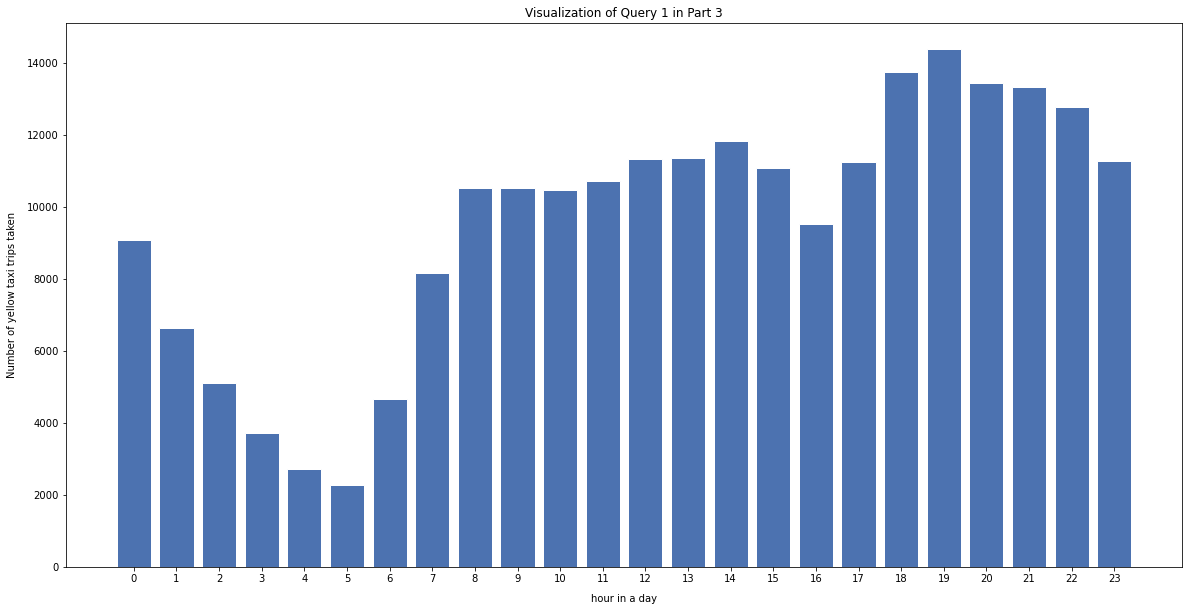

In [56]:
pickup_per_hour = get_data_for_visual_1(engine)
plot_visual_1(pickup_per_hour)

### Visualization 2
The average distance traveled per month with 90% confidence interval

In [57]:
def get_data_for_visual_2(engine):
    """
    Get data needed from dataframe to plot
    """
    QUERY_VISUAL_2 = """    
    SELECT hired_data.month, hired_data.distance
    FROM (
    SELECT STRFTIME("%m",pickup_datetime) as month, distance FROM uber_trips
    UNION ALL
    SELECT STRFTIME("%m",tpep_pickup_datetime) as month, trip_distance as distance FROM taxi_trips
    ) as hired_data
    """
    df = pd.DataFrame(engine.execute(QUERY_VISUAL_2).fetchall())
    rows  = [x for x in df.index if df.iloc[x][1]>1000]
    df.drop(rows,axis=0,inplace=True)
    return df

In [58]:
pickup_distance_month = get_data_for_visual_2(engine)

In [59]:
pickup_distance_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425245 entries, 0 to 425245
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   month     425245 non-null  object 
 1   distance  425245 non-null  float64
dtypes: float64(1), object(1)
memory usage: 9.7+ MB


In [60]:
pickup_distance_month

,month,distance
0,05,1.683851
1,07,2.458361
2,08,5.037958
3,06,1.662205
4,08,4.476855
...,...,...
425241,12,0.010000
425242,12,4.150000
425243,12,1.760000
425244,12,1.700000


In [61]:
monthly_distance = {}
for i in range(0,12):
    monthly_distance[i]= []

In [62]:
for row in pickup_distance_month.values.tolist():
    monthly_distance[int(row[0])-1].append(row[1])

In [63]:
# Create 90% confidence interval for population mean weight
means, conf_ls, conf_rs = [], [], []
for key, data in monthly_distance.items():
    import scipy.stats as st
    m = np.mean(data)
    l, r = st.norm.interval(alpha=0.90, loc=np.mean(data), scale=st.sem(data))
    means.append(m)
    conf_ls.append(l)
    conf_rs.append(r)

In [64]:
def plot_visual_2(means, conf_ls, conf_rs):
    """
    Set up plot style and axes labels
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    values = means  
    x=np.arange(12)
    axes.plot(x,values)
    axes.fill_between(x, conf_ls, conf_rs, color='b', alpha=.1)
    plt.ylabel("Distance: km", labelpad=10.0)
    plt.xticks(np.arange(12),['January','February','March','April','May','June','July','August','September','October','November','December'])
    axes.set_title("average distance traveled per month")
    plt.show()

In [65]:
means

[2.8862348362072576,
 2.9034070707210855,
 3.0136310452726796,
 3.052855297954434,
 3.120133630880689,
 3.1119375999675998,
 3.079948871110844,
 3.102188531792035,
 3.0908880442271354,
 3.0875707131122714,
 3.0427728698208387,
 3.02544319513223]

In [66]:
conf_ls

[2.858747171611115,
 2.8740181374177167,
 2.983041748092164,
 3.0244300531354313,
 3.090983809108081,
 3.0826276822854513,
 3.048968865928606,
 3.0700343957070624,
 3.0597352266641367,
 3.056619148991705,
 3.0119418424183273,
 2.994497896596743]

In [67]:
conf_rs

[2.9137225008034005,
 2.9327960040244543,
 3.0442203424531953,
 3.081280542773437,
 3.149283452653297,
 3.1412475176497483,
 3.1109288762930816,
 3.134342667877007,
 3.122040861790134,
 3.1185222772328376,
 3.07360389722335,
 3.056388493667717]

In [68]:
june_data = monthly_distance[5]
for item in june_data:
    if item > 100:
        print(f"Long distance: {item}")   

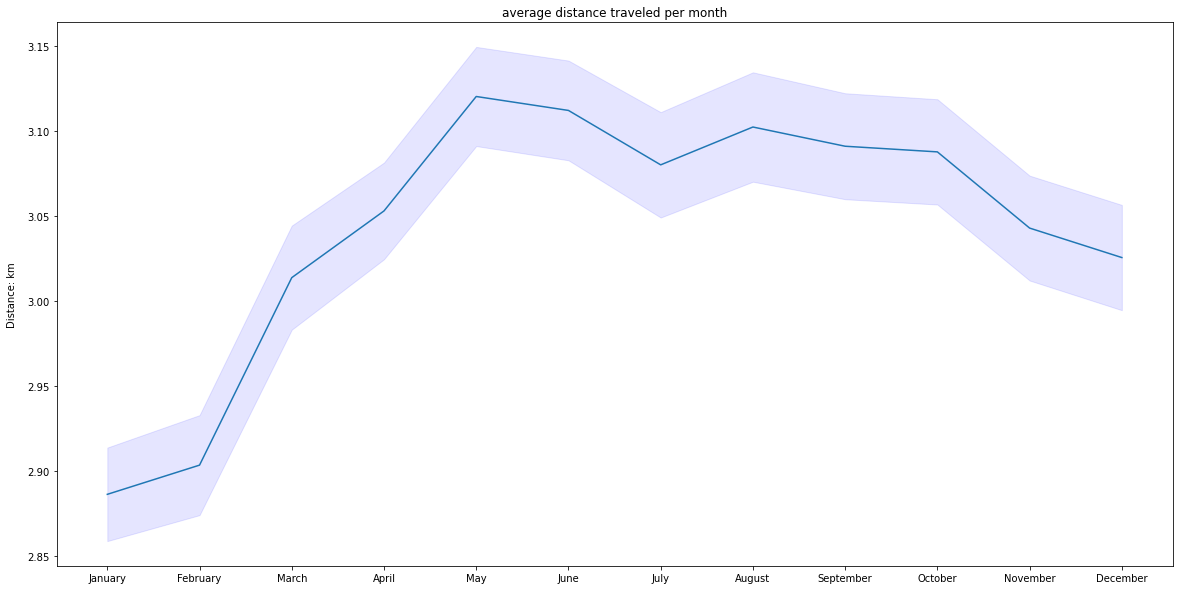

In [69]:
plot_visual_2(means, conf_ls, conf_rs)

### Visualization 3
The most popular day of the week for drop offs for each NYC airport

In [70]:
def get_data_for_visual_3(engine):
    """
    Get data needed from dataframe to plot
    """
    QUERY_VISUAL_3 = """    
        SELECT STRFTIME("%w",pickup_datetime), dropoff_longitude, dropoff_latitude
        FROM uber_trips
    """
    df = pd.DataFrame(engine.execute(QUERY_VISUAL_3).fetchall())
    return df

In [71]:
drop_location = get_data_for_visual_3(engine)

In [72]:
drop_location

,"STRFTIME(""%w"",pickup_datetime)",dropoff_longitude,dropoff_latitude
0,4,-73.999512,40.723217
1,5,-73.994710,40.750325
2,1,-73.962565,40.772647
3,5,-73.965316,40.803349
4,4,-73.973082,40.761247
...,...,...,...
195467,0,-73.986525,40.740297
195468,5,-74.006672,40.739620
195469,1,-73.858957,40.692588
195470,3,-73.983215,40.695415


In [73]:
# Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR
LGA = (-73.8740, 40.7769)
JFK = (-73.7781, 40.6413)
EWR = (-74.1745, 40.6895)
import math
def make_bounding_box(location, distance=10):
    """
    Define the location for each airport center on bounding box that is square with sides of distance, and finally return left_lon,right_lon, up_lat, down_lat
    """
    lon , lat = location 
    #radius of the earth
    radius=6371
    #Find the longtitude interval
    c_lon = distance / radius / 2.0 / math.pi * 180 
    # print(c_lon)
    #Find the current latitude radius
    temp_r = math.sqrt(radius**2 - (radius* math.sin(lat))**2) 
    #Find the latitude interval
    c_lat = distance / temp_r / 2.0 / math.pi * 180
    return lon-c_lon, lon+c_lon, lat - c_lat, lat + c_lat

In [74]:
def check_bbox(bbox,location):
    # print(bbox)
    return location[0]>=bbox[0] and location[0]<=bbox[1] and location[1]>=bbox[2] and location[1]<=bbox[3]

In [75]:
JFK_bbox=make_bounding_box(JFK)

In [76]:
EWR_bbox=make_bounding_box(EWR)

In [77]:
LGA_bbox=make_bounding_box(LGA)

In [78]:
group = drop_location.groupby('STRFTIME("%w",pickup_datetime)')

In [79]:
weekday_data = list(group)

In [80]:
weekday_data[0][1]

,"STRFTIME(""%w"",pickup_datetime)",dropoff_longitude,dropoff_latitude
6,0,-73.871195,40.774297
45,0,-73.984879,40.760651
51,0,-73.944454,40.834959
59,0,-74.010737,40.711715
68,0,-73.990135,40.757439
...,...,...,...
195438,0,-73.901523,40.902372
195451,0,-73.963186,40.757905
195460,0,-73.990730,40.738980
195462,0,-73.952240,40.772957


In [81]:
count_JFK, count_EWR, count_LGA = [0]*7,[0]*7,[0]*7
for idx,item in enumerate(weekday_data):
    day_df = item[1]
    for row in day_df.values.tolist():
        location=tuple(row[1:])
        # print("location:",location)
        if check_bbox(bbox=JFK_bbox, location=location):
            count_JFK[idx]+=1          
        if check_bbox(bbox=EWR_bbox, location=location):
            count_EWR[idx]+=1        
        if check_bbox(bbox=LGA_bbox, location=location):
            count_LGA[idx]+=1
print(count_JFK)
print(count_EWR)
print(count_LGA)

[273, 236, 208, 244, 265, 260, 222]
[60, 41, 33, 46, 41, 38, 32]
[772, 652, 595, 659, 726, 787, 661]


In [82]:
def plot_visual_3(y1,y2,y3):
    """
    Set up plot style and axes labels
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    x = np.arange(len(y1))
    width=0.5
    rects1 = axes.bar((x - width/2), y1, width/2, label='JFK')
    rects2 = axes.bar(x,             y2, width/2, label='EWR')
    rects3 = axes.bar((x + width/2), y3, width/2, label='LGA')
    plt.xlabel("weekday", labelpad=10.0)
    plt.ylabel("Number of hired trips", labelpad=10.0)
    plt.xticks(np.arange(7),['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
    axes.set_title("Most Popular day of the week to dropff for each airport")
    plt.show()

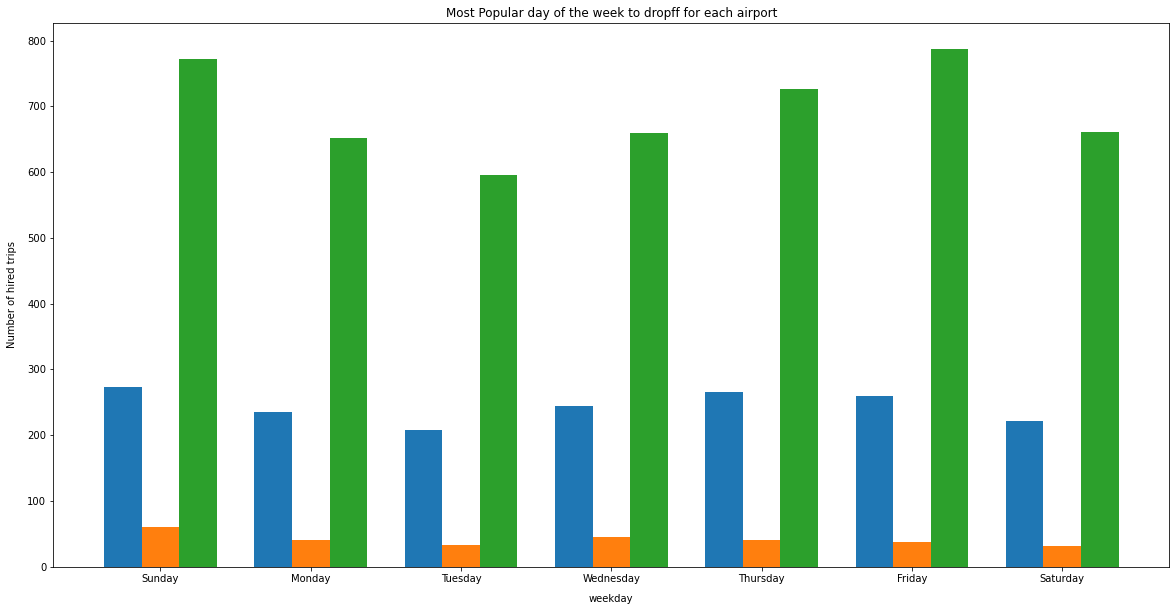

In [83]:
plot_visual_3(count_JFK,count_EWR,count_LGA)

### Visualization 4
Heatmap of hired trips

In [93]:
def get_data_for_visual_4(engine):
    """
    Get data needed from dataframe to plot
    """
    QUERY_VISUAL_4 = """    
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
        FROM uber_trips
    """
    df = pd.DataFrame(engine.execute(QUERY_VISUAL_4).fetchall())
    return df

In [94]:
trip_df = get_data_for_visual_4(engine)

In [96]:
def plot_visual_4(df):
    """
    use Kerpler to plot the map
    """
    from keplergl import KeplerGl
    %run map_config.py
    map_1 = KeplerGl(data={'test_data':df},config=config)
    return map_1

In [98]:
plot_visual_4(trip_df)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'w20wont', 'type': …

### Visualization 5
Scatter plot to compare tip amount with distance

In [84]:
def get_data_for_visual_5(engine):
    """
    Get data needed from dataframe to plot
    """
    QUERY_VISUAL_5 = """     
    SELECT trip_distance as distance, tip_amount 
    FROM taxi_trips
    """ 
    df = pd.DataFrame(engine.execute(QUERY_VISUAL_5).fetchall())
    rows  = [x for x in df.index if df.iloc[x][0]>1000]
    df.drop(rows,axis=0,inplace=True)
    return df

In [85]:
def plot_visual_5(dataframe):
    """
    Set up plot style and axes labels
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    distance = [row[0] for row in dataframe.values.tolist()]
    tip = [row[1] for row in dataframe.values.tolist()]
    plt.scatter(x=distance,y=tip, s=5)
    plt.xlabel("Trip Distance: km", labelpad=10.0)
    plt.ylabel("Amount of tips: $", labelpad=10.0)
    axes.set_title("Relationship between tip and distance")
    plt.show()

In [86]:
tip_distance = get_data_for_visual_5(engine)

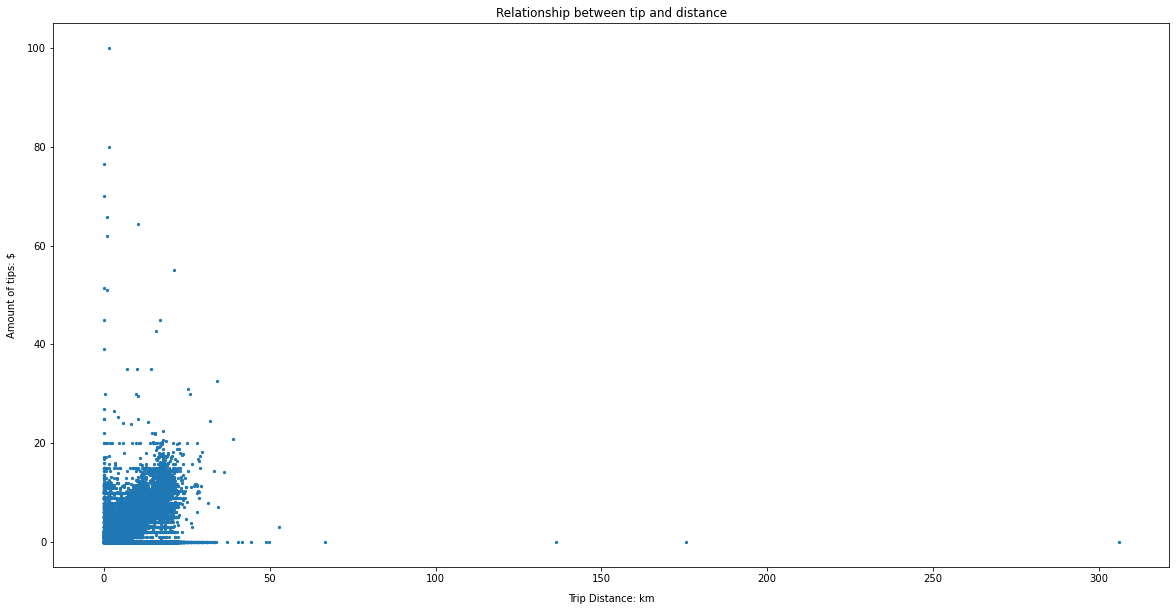

In [87]:
plot_visual_5(tip_distance)

### Visualization 6
Scatter plot to compare tip amount with precipitation amount

In [88]:
def get_data_for_visual_6(engine):
    """
    Get data needed from dataframe to plot
    """
    QUERY_VISUAL_6 = """    
    SELECT hired_data.tip_amount, HourlyPrecipitation
    FROM (
        SELECT tpep_pickup_datetime as pickup_datetime, tip_amount
        FROM taxi_trips
    ) as hired_data

    INNER JOIN hourly_weather
    ON STRFTIME('%Y', hired_data.pickup_datetime) = STRFTIME('%Y', hourly_weather.day) 
    AND STRFTIME('%j', hired_data.pickup_datetime) = STRFTIME('%j', hourly_weather.day) 
    AND STRFTIME('%H', hired_data.pickup_datetime) = hourly_weather.hour;

    """
    df = pd.DataFrame(engine.execute(QUERY_VISUAL_6).fetchall())
    return df

In [89]:
tip_weather = get_data_for_visual_6(engine)
tip_weather

,tip_amount,HourlyPrecipitation
0,2.30,0.00
1,1.55,0.00
2,1.00,0.00
3,0.00,0.00
4,2.10,0.00
...,...,...
226230,0.00,0.15
226231,0.00,0.29
226232,0.00,0.32
226233,0.00,0.00


In [91]:
def plot_visual_6(dataframe): 
    """
    Set up plot style and axes labels
    """
    figure, axes = plt.subplots(figsize=(20, 10))

    tip = [row[0] for row in dataframe.values.tolist()]
    precipitation = [row[1] for row in dataframe.values.tolist()]
    plt.scatter(x=precipitation,y=tip, s=5)
    plt.xlabel("Hourly Precipitation", labelpad=10.0)
    plt.ylabel("Amount of tips: $", labelpad=10.0)
    axes.set_title("Relationship between tip and hourly precipitation")
    
    plt.show()

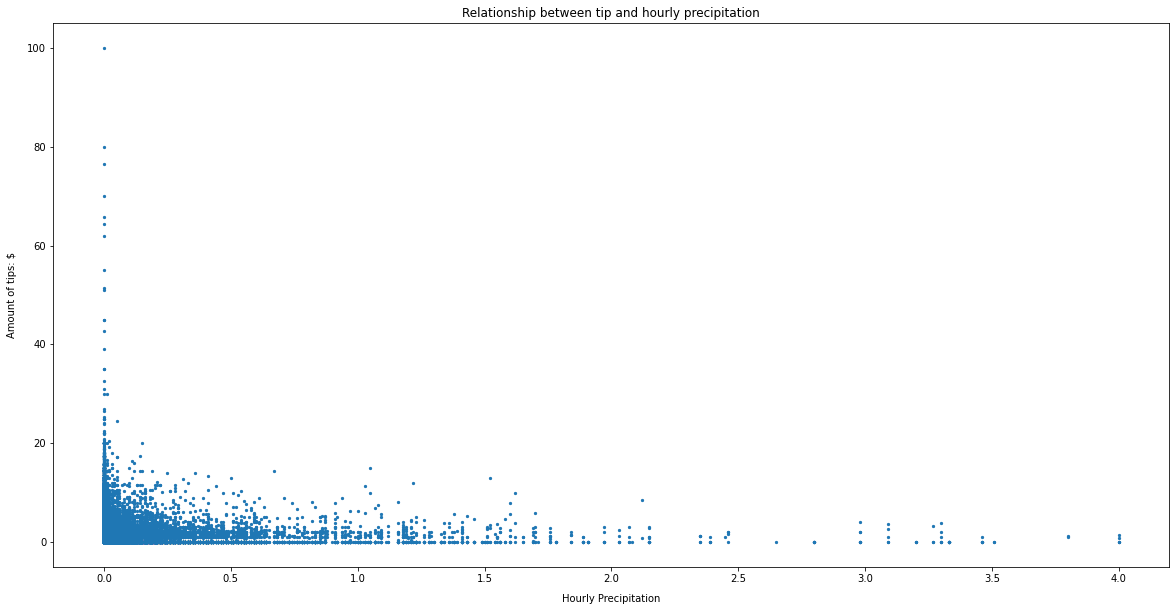

In [92]:
plot_visual_6(tip_weather)